In [1]:
import os
import cv2
import numpy as np
import random as rn
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split

## Dataloader

In [2]:
class LaneDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        # Standard JetBot transforms + Color Augmentation
        self.transform = transform if transform else transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            # Normalize using ImageNet stats (standard for ResNet)
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0] # Filename
        img_path = os.path.join(self.root_dir, img_id)
        
        # Check if file exists in folder
        if not os.path.exists(img_path):
            return self.__getitem__((index + 1) % len(self.annotations))
        
        image = Image.open(img_path).convert("RGB")
        
        # Get the X, Y coordinates
        label = torch.tensor(
            self.annotations.iloc[index, 1:3].values.astype('float32')
        ) # Columns 1 and 2 are x_norm, y_norm

        if self.transform:
            image = self.transform(image)

        return image, label

# Test with random images

In [3]:
class EleveNet(nn.Module):
    def __init__(self, dropout_prob=0.3):
        super(EleveNet, self).__init__()
        
        # Input dimensions: (batch_size, 3, 224, 224)
        
        # Convolutional layers with batch norm
        self.conv1 = nn.Conv2d(3, 28, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(28)
        self.conv2 = nn.Conv2d(28, 56, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(56)
        self.conv3 = nn.Conv2d(56, 112, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(112)
        #self.conv4 = nn.Conv2d(112, 224, kernel_size=3, padding=1)
        #self.bn4 = nn.BatchNorm2d(224)

        self.pooling = nn.MaxPool2d(2, 2)  # Standard pooling
        
        # for flexible input image resolutions use adaptive pooling:
        # self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))
        
        self.relu = nn.ReLU()
        self.silu = nn.SiLU()
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(112 * 28 * 28, 15)  # 224 * 14 * 14 # prev 192
        self.bn7 = nn.BatchNorm1d(15) # prev 192

        self.dropout = nn.Dropout(p=dropout_prob)
        self.output = nn.Linear(15, 2)

    def forward(self, x):
        # Input x dimensions: (batch_size, 3, 224, 224)
        
        # Conv block 1
        x = self.conv1(x)  # (batch_size, 28, 224, 224)
        x = self.bn1(x)
        x = self.pooling(x)  # (batch_size, 28, 112, 112)
        #x = self.silu(x)     # x = self.relu()
        x = self.relu(x)
        
        # Conv block 2
        x = self.conv2(x)  # (batch_size, 56, 112, 112)
        x = self.bn2(x)
        x = self.pooling(x)  # (batch_size, 56, 56, 56)
        #x = self.silu(x)
        x = self.relu(x)
        
        # Conv block 3
        x = self.conv3(x)  # (batch_size, 112, 56, 56)
        x = self.bn3(x)
        x = self.pooling(x)  # (batch_size, 112, 28, 28)
        #x = self.silu(x)
        x = self.relu(x)

        # Conv block 4
        #x = self.conv4(x)  # (batch_size, 224, 28, 28)
        #x = self.bn4(x)
        #x = self.pooling(x)  # (batch_size, 224, 14, 14)
        #x = self.silu(x)
        #x = self.relu(x)

        # Flatten
        # After 4 pooling layers: (batch_size, 224, 14, 14)
        x = self.flatten(x)  # (batch_size, 224 * 14 * 14) = (batch_size, 43904)

        # Adaptive pooling for flexible image size
        #x = self.adaptive_pool(x)  # (batch_size, 1024, 3, 3)
        
        x = self.linear1(x)  # (batch_size, 192)
        x = self.bn7(x)
        #x = self.silu(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.output(x)  # (batch_size, num_classes)

        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
#data_dir = r"C:\Users\agah2\Desktop\JupyterNotebooks\BIP\BIP_images_roboter_cam_allinone\val"
#data_dir = "./dataset/all_original"

data_dir = "./dataset/test_original"
csv_file = "./dataset/labels_original.csv"

In [6]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # ImageNet mean and std
    transforms.ConvertImageDtype(torch.float)
])

In [7]:
# Predict with MobileNetV3
def predict_image_mobilenet(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)
    image = image.unsqueeze(0)
    
    model_mobilenet.eval()  # Disables traininng
    
    with torch.no_grad():
        image_mobilenet = image 
        output_mobilenet = model_mobilenet(image_mobilenet)
    
    return output_mobilenet # Return just the string label instead of array

In [8]:
# Predict with ResNet18
def predict_image_resnet(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)
    image = image.unsqueeze(0)
    
    model_resnet.eval()  # Disables traininng
    
    with torch.no_grad():
        image_resnet = image.to(device)  # Fixed: assign back to image
        output_resnet = model_resnet(image_resnet)
    
    return output_resnet  # Return just the string label instead of array

In [9]:
# Predict with SqueezeNet1
def predict_image_squeezenet(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)
    image = image.unsqueeze(0)
    
    model_squeezenet.eval()  # Disables traininng
    
    with torch.no_grad():
        image_squeezenet = image.to(device)  # Fixed: assign back to image
        output_squeezenet = model_squeezenet(image_squeezenet)
    
    return output_squeezenet  # Return just the string label instead of array

In [10]:
# Predict with EleveNet
def predict_image_elevenet(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)
    image = image.unsqueeze(0)
    
    model_elevenet.eval()  # Disables traininng
    
    with torch.no_grad():
        image_elevenet = image.to(device)  # Fixed: assign back to image
        output_elevenet = model_elevenet(image_elevenet)
    
    return output_elevenet  # Return just the string label instead of array

## Setup Model MobileNet

In [11]:
# Load Mobilenet pre-trained on ImageNet
model_mobilenet = models.mobilenet_v3_small(weights_only=True) # mobilenet_v3_large also exists

# Modify the final layer: Input features -> 2 Output features (X, Y)
in_features_mobilenet = model_mobilenet.classifier[-1].in_features
model_mobilenet.classifier[-1] = nn.Linear(in_features_mobilenet, 2)
print(model_mobilenet.classifier)

model_mobilenet.load_state_dict(torch.load('./models/best_steering_model_xy_MobileNetV3.pth'), strict=False)
model_mobilenet.to(device)
model_mobilenet.eval()
print("Loaded MobileNetV3 Model")

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=2, bias=True)
)
Loaded MobileNetV3 Model


C:\Users\agah2\AppData\Local\Temp\ipykernel_18656\3399502827.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mobilenet.load_state_dict(torch.load('./models/best_st

## Setup Model ResNet

In [12]:
# Load Mobilenet pre-trained on ImageNet
model_resnet = models.resnet18(weights = True) # prev: weights = True

# Modify the final layer: Input features -> 2 Output features (X, Y)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 2)
print(model_resnet.fc)

model_resnet.load_state_dict(torch.load('./models/best_steering_model_xy_ResNet18.pth'))
model_resnet.to(device)
model_resnet.eval()
print("Loaded ResNet18 Model")

C:\Users\agah2\miniconda3\envs\bip\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\agah2\AppData\Local\Temp\ipykernel_18656\2569679210.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects 

Linear(in_features=512, out_features=2, bias=True)
Loaded ResNet18 Model


## Setup Model SqueezeNet

In [13]:
# Load Mobilenet pre-trained on ImageNet
model_squeezenet = models.squeezenet1_1(weights = True) # prev: weights = True

# Modify the final layer: Input features -> 2 Output features (X, Y)
in_channels_squeezenet = model_squeezenet.classifier[1].in_channels
print(model_squeezenet.classifier)

model_squeezenet.classifier[1] = nn.Conv2d(
    in_channels_squeezenet, 
    2,  # New number of output channels (for X, Y)
    kernel_size=(1, 1), 
    stride=(1, 1)
)

model_squeezenet.classifier = nn.Sequential(
    nn.Dropout(p=0.5), # Keep the original dropout
    model_squeezenet.classifier[1], # Use the newly modified Conv2d layer
    nn.ReLU(inplace=True), # Keep the ReLU
    nn.AdaptiveAvgPool2d((1, 1)) # Keep the pooling layer
)

model_squeezenet.load_state_dict(torch.load('./models/best_steering_model_xy_SqueezeNet1.pth'))
model_squeezenet.to(device)
model_squeezenet.eval()
print("Loaded SqueezeNet Model")

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)
Loaded SqueezeNet Model


C:\Users\agah2\miniconda3\envs\bip\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\agah2\AppData\Local\Temp\ipykernel_18656\3165196902.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitra

# Setup Model EleveNet

In [14]:
# Load Mobilenet pre-trained on ImageNet
model_elevenet = EleveNet()

model_elevenet.load_state_dict(torch.load('./models/best_steering_model_xy_EleveNet.pth'))
model_elevenet.to(device)
model_elevenet.eval()
print("Loaded EleveNet Model")

Loaded EleveNet Model


C:\Users\agah2\AppData\Local\Temp\ipykernel_18656\2009934612.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_elevenet.load_state_dict(torch.load('./models/best_ste

## Pick random image and predict 

In [35]:
# Load random image
directory = Path(data_dir)
images = [file for file in directory.iterdir()]

random_image = rn.choice(images)
print(f"Random image: {random_image.name}")

image_path = random_image
image = Image.open(image_path).convert('RGB')
image_cv = cv2.imread(image_path)

Random image: frame_001914.png


## Get ground truth for random image

In [36]:
test_dir = "./dataset/test_original"   # Testing Dataset
test_dataset = LaneDataset(csv_file = csv_file, root_dir = test_dir)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [26]:
images, labels = next(iter(test_loader))

In [27]:
image = images[0]
image_to_show = image.permute(1, 2, 0).numpy()
image_cv = cv2.imread(image_path)

In [28]:
label = labels[0]

In [29]:
xpred = label[0]
ypred = label[1]

print(f"x = {xpred}, y = {ypred}")

x = 0.7366071343421936, y = 0.5580357313156128


In [30]:
pred_x = int(np.clip(xpred * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y = int(np.clip(ypred * image_cv.shape[1], 0, image_cv.shape[1] - 1))

print(f"x: {pred_x}")
print(f"y: {pred_y}")

x: 165
y: 125


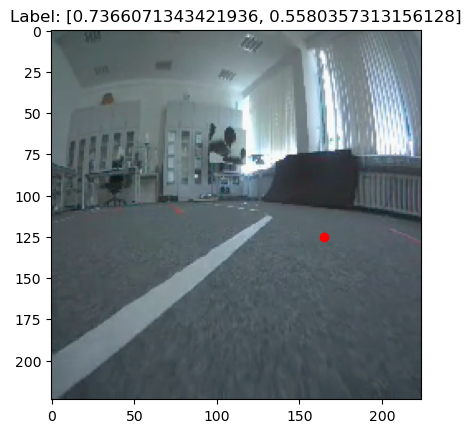

In [31]:
plt.imshow(image_to_show)
plt.plot(pred_x, pred_y, "ro")
plt.title(f"Label: {labels[0].tolist()}")
plt.show()

In [32]:
# Define transform function
to_tensor = transforms.ToTensor()

# Transform image back to Tensor
image = to_tensor(image_to_show).permute(1, 2, 0)

print(image.shape) # Output: torch.Size([3, H, W])

torch.Size([224, 224, 3])


In [33]:
# MobileNet -----------------------------------------------------------------------------------------
output_mobilenet = predict_image_mobilenet(image_path).cpu() #.numpy()
print(f"Output Mobilenet: {output_mobilenet}")

pred_coord_mobilenet = output_mobilenet
print(pred_coord_mobilenet)

coordinates_mobilenet = pred_coord_mobilenet[0]
xpred_mobilenet = coordinates_mobilenet[0]
ypred_mobilenet = coordinates_mobilenet[1]
#print(f"x = {xpred_mobilenet}, y = {ypred_mobilenet} \n")


pred_x_mobilenet = int(np.clip(xpred_mobilenet * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_mobilenet = int(np.clip(ypred_mobilenet * image_cv.shape[0], 0, image_cv.shape[0] - 1))
print(f"x = {pred_x_mobilenet}, y = {pred_y_mobilenet} \n")



# ResNet ---------------------------------------------------------------------------------------------
output_resnet = predict_image_resnet(image_path).cpu() #.numpy()
print(f"Output Mobilenet: {output_resnet}")

pred_coord_resnet = output_resnet
print(pred_coord_resnet)

coordinates_resnet = pred_coord_resnet[0]
xpred_resnet = coordinates_resnet[0]
ypred_resnet = coordinates_resnet[1]
#print(f"x = {xpred_resnet}, y = {ypred_resnet} \n")


pred_x_resnet = int(np.clip(xpred_resnet * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_resnet = int(np.clip(ypred_resnet * image_cv.shape[0], 0, image_cv.shape[0] - 1))
print(f"x = {pred_x_resnet}, y = {pred_y_resnet} \n")





# SqueezeNet -----------------------------------------------------------------------------------------
output_squeezenet = predict_image_squeezenet(image_path).cpu() #.numpy()
print(f"Output Mobilenet: {output_squeezenet}")

pred_coord_squeezenet = output_squeezenet
print(pred_coord_squeezenet)

coordinates_squeezenet = pred_coord_squeezenet[0]
xpred_squeezenet = coordinates_squeezenet[0]
ypred_squeezenet = coordinates_squeezenet[1]
#print(f"x = {xpred_squeezenet}, y = {ypred_squeezenet}")


pred_x_squeezenet = int(np.clip(xpred_squeezenet * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_squeezenet = int(np.clip(ypred_squeezenet * image_cv.shape[0], 0, image_cv.shape[0] - 1))
print(f"x = {pred_x_squeezenet}, y = {pred_y_squeezenet} \n")




# EleveNet ----------------------------------------------------------------------------------------
output_elevenet = predict_image_elevenet(image_path).cpu() #.numpy()
print(f"Output Elevenet: {output_elevenet}")

pred_coord_elevenet = output_elevenet
print(pred_coord_elevenet)

coordinates_elevenet = pred_coord_elevenet[0]
xpred_elevenet = coordinates_elevenet[0]
ypred_elevenet = coordinates_elevenet[1]
#print(f"x = {xpred_elevenet}, y = {ypred_elevenet}")


# Prediction Elevenet (Green Circle)
pred_x_norm_elevenet = xpred_elevenet
pred_y_norm_elevenet = ypred_elevenet

pred_x_elevenet = int(np.clip(pred_x_norm_elevenet * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_elevenet = int(np.clip(pred_y_norm_elevenet * image_cv.shape[0], 0, image_cv.shape[0] - 1))
print(f"x = {pred_x_elevenet}, y = {pred_y_elevenet}")

Output Mobilenet: tensor([[0.4095, 0.6255]])
tensor([[0.4095, 0.6255]])
x = 91, y = 140 

Output Mobilenet: tensor([[0.4005, 0.6155]])
tensor([[0.4005, 0.6155]])
x = 89, y = 137 

Output Mobilenet: tensor([[0.4048, 0.6110]])
tensor([[0.4048, 0.6110]])
x = 90, y = 136 

Output Elevenet: tensor([[0.4855, 0.5301]])
tensor([[0.4855, 0.5301]])
x = 108, y = 118


## Plot all predictions in one plot

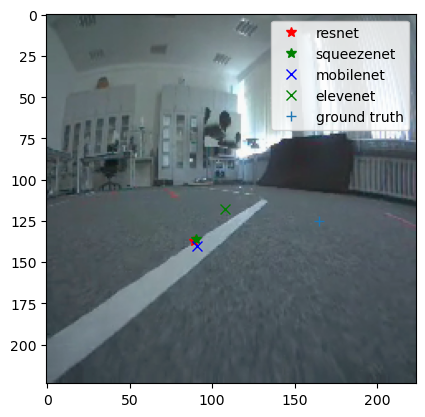

In [34]:
plt.imshow(image)
plt.plot(pred_x_resnet, pred_y_resnet, 'r*', label = "resnet", markersize = 7)
plt.plot(pred_x_squeezenet, pred_y_squeezenet, 'g*', label = "squeezenet", markersize = 7)
plt.plot(pred_x_mobilenet, pred_y_mobilenet, 'bx', label = "mobilenet", markersize = 7)
plt.plot(pred_x_elevenet, pred_y_elevenet, 'gx', label = "elevenet", markersize = 7)
plt.plot(pred_x, pred_y, "+", label = "ground truth", markersize = 7)
plt.legend()

plt.savefig('./ReportImages/ModelPredComparison.jpg', bbox_inches='tight', dpi=300)

## Plot all predictions seperately

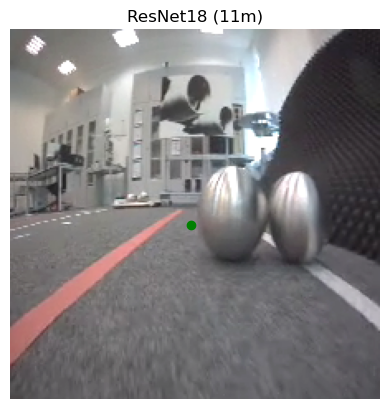

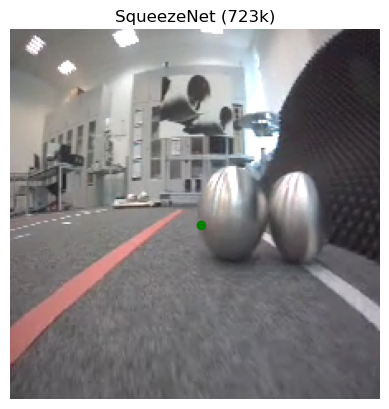

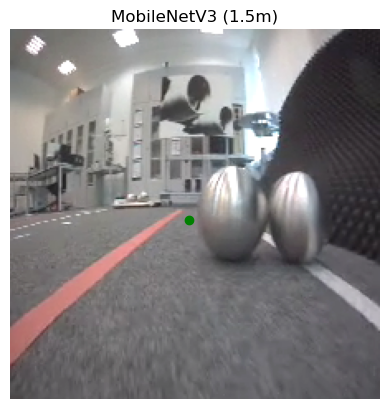

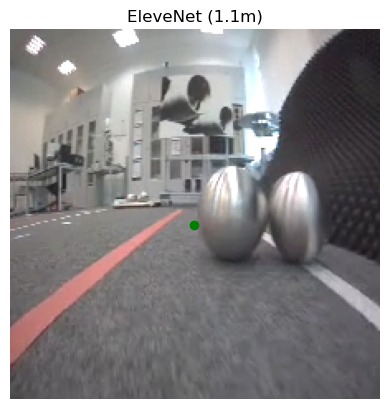

MobileNet Prediction: x = 108, y = 115 

ResNet Prediction: x = 109, y = 118 

SqueezeNet Prediction: x = 115, y = 118 

EleveNet Prediction: x = 111, y = 118


In [131]:
#plt.figure(figsize=(12,6))
#plt.title("Comparison")

#plt.subplot(1,4,1)
plt.imshow(image)  # convert from C,H,W → H,W,C
plt.plot(pred_x_resnet, pred_y_resnet, 'go')
plt.title("ResNet18 (11m)")
plt.axis("off")
#plt.savefig("resnet_pred.jpg", bbox_inches='tight', dpi=300)
plt.show()


#plt.subplot(1,4,2)
plt.imshow(image)  # convert from C,H,W → H,W,C
plt.plot(pred_x_squeezenet, pred_y_squeezenet, 'go')
plt.title("SqueezeNet (723k)")
plt.axis("off")
#plt.savefig("squeezenet_pred.jpg", bbox_inches='tight', dpi=300)
plt.show()


#plt.subplot(1,4,3)
plt.imshow(image)  # convert from C,H,W → H,W,C
plt.plot(pred_x_mobilenet, pred_y_mobilenet, 'go')
plt.title("MobileNetV3 (1.5m)")
plt.axis("off")
#plt.savefig("mobilenet_pred.jpg", bbox_inches='tight', dpi=300)
plt.show()


#plt.subplot(1,4,4)
plt.imshow(image)  # convert from C,H,W → H,W,C
plt.plot(pred_x_elevenet, pred_y_elevenet, 'go')
plt.title("EleveNet (1.1m)")
plt.axis("off")
#plt.savefig("elevenet_pred.jpg", bbox_inches='tight', dpi=300)
plt.show()


#plt.show()
#plt.savefig("old_dataset_14122025")

print(f"MobileNet Prediction: x = {pred_x_mobilenet}, y = {pred_y_mobilenet} \n")
print(f"ResNet Prediction: x = {pred_x_resnet}, y = {pred_y_resnet} \n")
print(f"SqueezeNet Prediction: x = {pred_x_squeezenet}, y = {pred_y_squeezenet} \n")
print(f"EleveNet Prediction: x = {pred_x_elevenet}, y = {pred_y_elevenet}")

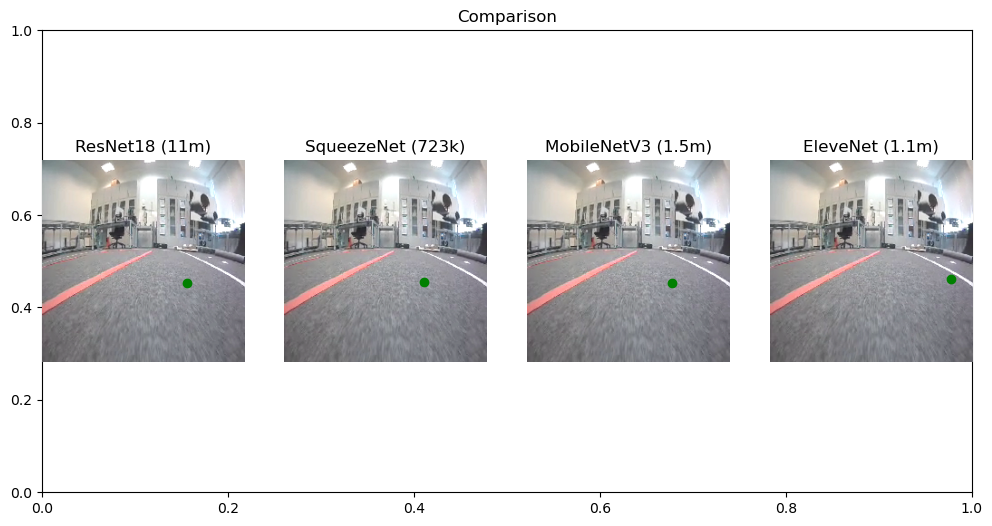

MobileNet Prediction: x = 160, y = 136 

ResNet Prediction: x = 160, y = 136 

SqueezeNet Prediction: x = 154, y = 134 

EleveNet Prediction: x = 200, y = 131


In [53]:
#plt.figure(figsize=(12,6))
#fig, ax = plt.subplots(figsize = (12,6))
plt.figure(figsize=(12,6))
plt.title("Comparison")

plt.subplot(1,4,1)
plt.imshow(image)  # convert from C,H,W → H,W,C
plt.plot(pred_x_resnet, pred_y_resnet, 'go')
plt.title("ResNet18 (11m)")
plt.axis("off")


plt.subplot(1,4,2)
plt.imshow(image)  # convert from C,H,W → H,W,C
plt.plot(pred_x_squeezenet, pred_y_squeezenet, 'go')
plt.title("SqueezeNet (723k)")
plt.axis("off")


plt.subplot(1,4,3)
plt.imshow(image)  # convert from C,H,W → H,W,C
plt.plot(pred_x_mobilenet, pred_y_mobilenet, 'go')
plt.title("MobileNetV3 (1.5m)")
plt.axis("off")


plt.subplot(1,4,4)
plt.imshow(image)  # convert from C,H,W → H,W,C
plt.plot(pred_x_elevenet, pred_y_elevenet, 'go')
plt.title("EleveNet (1.1m)")
plt.axis("off")


plt.show()
#plt.savefig("old_dataset_14122025")

print(f"MobileNet Prediction: x = {pred_x_mobilenet}, y = {pred_y_mobilenet} \n")
print(f"ResNet Prediction: x = {pred_x_resnet}, y = {pred_y_resnet} \n")
print(f"SqueezeNet Prediction: x = {pred_x_squeezenet}, y = {pred_y_squeezenet} \n")
print(f"EleveNet Prediction: x = {pred_x_elevenet}, y = {pred_y_elevenet}")

# Time Measurement

In [ ]:
# MobileNet
device = torch.device("cuda")
model_mobilenet.to(device).eval()

dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warm-up
for _ in range(20):
    _ = model_mobilenet(dummy_input)

# Setup for multiple runs
repetitions = 100
timings = np.zeros((repetitions, 1)) # Array to store results
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

#print(f"Starting {repetitions} iterations")

# Measurement Loop
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model_mobilenet(dummy_input)
        ender.record()
        
        # WAIT for GPU to finish the work of this specific iteration
        torch.cuda.synchronize()
        
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

# Statistics
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)

#print(f"\n Statistics")
print(f"MobileNet Average Inference Time: {mean_syn:.3f} ms")
print(f"MobileNet Standard Deviation:     {std_syn:.3f} ms")
print(f"MobileNet Throughput:             {1000/mean_syn:.2f} FPS \n")




# ResNet
model_resnet.to(device).eval()

# Warm-up
for _ in range(20):
    _ = model_resnet(dummy_input)

# Setup for multiple runs
timings = np.zeros((repetitions, 1)) # Array to store results
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

#print(f"Starting {repetitions} iterations")

# Measurement Loop
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model_resnet(dummy_input)
        ender.record()
        
        # WAIT for GPU to finish the work of this specific iteration
        torch.cuda.synchronize()
        
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

# Statistics
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)

#print(f"\n Statistics")
print(f"ResNet Average Inference Time: {mean_syn:.3f} ms")
print(f"ResNet Standard Deviation:     {std_syn:.3f} ms")
print(f"ResNet Throughput:             {1000/mean_syn:.2f} FPS \n")



# SqueezeNet
model_squeezenet.to(device).eval()

# Warm-up
for _ in range(20):
    _ = model_squeezenet(dummy_input)

# Setup for multiple runs
timings = np.zeros((repetitions, 1)) # Array to store results
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

#print(f"Starting {repetitions} iterations")

# Measurement Loop
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model_squeezenet(dummy_input)
        ender.record()
        
        # WAIT for GPU to finish the work of this specific iteration
        torch.cuda.synchronize()
        
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

# Statistics
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)

#print(f"\n Statistics")
print(f"SqueezeNet Average Inference Time: {mean_syn:.3f} ms")
print(f"SqueezeNet Standard Deviation:     {std_syn:.3f} ms")
print(f"SqueezeNet Throughput:             {1000/mean_syn:.2f} FPS \n")



# EleveNet
model_elevenet.to(device).eval()

# Warm-up
for _ in range(20):
    _ = model_elevenet(dummy_input)

# Setup for multiple runs
timings = np.zeros((repetitions, 1)) # Array to store results
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

#print(f"Starting {repetitions} iterations")

# Measurement Loop
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model_elevenet(dummy_input)
        ender.record()
        
        # WAIT for GPU to finish the work of this specific iteration
        torch.cuda.synchronize()
        
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

# Statistics
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)

#print(f"\n Statistics")
print(f"EleveNet Average Inference Time: {mean_syn:.3f} ms")
print(f"EleveNet Standard Deviation:     {std_syn:.3f} ms")
print(f"EleveNet Throughput:             {1000/mean_syn:.2f} FPS \n")